In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
from tqdm import tqdm
import tensorflow as tf
import time 
import warnings
warnings.filterwarnings("ignore")
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import math
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
FOLDERNAME = '가스수요량'
assert FOLDERNAME is not None, "[!] Enter the foldername."
import plotly.express as px
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%matplotlib inline 
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/가스수요량


In [2]:
!pip install xgboost

In [71]:
total = pd.read_csv('한국가스공사_시간별 공급량_20181231.csv',  header=0, encoding='cp949')
temper = pd.read_csv('temperture.csv', error_bad_lines=False)
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [72]:
rain = pd.read_csv('강수량.csv', error_bad_lines=False)
wind = pd.read_csv('풍속.csv', error_bad_lines=False)

In [73]:
rain = rain[['일시','last_rain']]
wind = wind[['일시','last_avg_windspeed','last_max_windspeed']]

In [74]:
wind

,일시,last_avg_windspeed,last_max_windspeed
0,2012-01-01,NaN,NaN
1,2012-01-02,2.9,12.6
2,2012-01-03,2.3,6.1
3,2012-01-04,2.5,10.3
4,2012-01-05,3.1,8.7
...,...,...,...
2917,2019-12-27,2.4,9.0
2918,2019-12-28,2.1,7.7
2919,2019-12-29,2.0,5.8
2920,2019-12-30,2.9,6.6


In [75]:
wind["일시"]=wind["일시"].astype(str)
rain["일시"]=rain["일시"].astype(str)
weather = pd.merge(wind, rain, on = '일시')
weather["일시"] = pd.to_datetime(weather['일시'])
weather['연월일'] = weather['일시']

In [76]:
weather

,일시,last_avg_windspeed,last_max_windspeed,last_rain,연월일
0,2012-01-01,NaN,NaN,NaN,2012-01-01
1,2012-01-02,2.9,12.6,0.0,2012-01-02
2,2012-01-03,2.3,6.1,0.0,2012-01-03
3,2012-01-04,2.5,10.3,0.4,2012-01-04
4,2012-01-05,3.1,8.7,0.0,2012-01-05
...,...,...,...,...,...
2917,2019-12-27,2.4,9.0,0.3,2019-12-27
2918,2019-12-28,2.1,7.7,0.0,2019-12-28
2919,2019-12-29,2.0,5.8,0.0,2019-12-29
2920,2019-12-30,2.9,6.6,1.4,2019-12-30


In [77]:
temper

,지점번호,지점명,일시,평균기온(℃),최고기온(℃),최고기온시각,최저기온(℃),최저기온시각,일교차,전일최저기온,전일평균기온
0,108,서울,2012-01-01,-3.0,0.4,0:01,-6.9,23:26,",7.3",-11.6,-8.7
1,108,서울,2012-01-02,-4.8,-1.2,13:57,-8.3,7:58,",7.1",-6.9,-3.0
2,108,서울,2012-01-03,-4.5,-0.2,12:52,-6.8,7:52,",6.6",-8.3,-4.8
3,108,서울,2012-01-04,-7.4,-4.3,15:52,-9.6,8:37,",5.3",-6.8,-4.5
4,108,서울,2012-01-05,-5.7,-1.3,15:42,-9.8,7:40,",8.5",-9.6,-7.4
...,...,...,...,...,...,...,...,...,...,...,...
2917,108,서울,2019-12-27,-1.7,2.6,14:42,-4.6,7:24,",7.2",-2.4,2.0
2918,108,서울,2019-12-28,1.1,6.1,13:47,-3.6,3:36,",9.7",-4.6,-1.7
2919,108,서울,2019-12-29,3.8,6.2,15:25,1.1,0:43,",5.1",-3.6,1.1
2920,108,서울,2019-12-30,2.7,6.8,11:31,-5.7,23:59,",12.5",1.1,3.8


In [78]:
weather['일시'] =  weather['일시'].astype(str)
temper["일시"] = temper["일시"].astype(str)
weather = pd.merge(weather, temper, on = '일시')
weather['연월일'] = weather['일시']

In [79]:
weather

,일시,last_avg_windspeed,last_max_windspeed,last_rain,연월일,지점번호,지점명,평균기온(℃),최고기온(℃),최고기온시각,최저기온(℃),최저기온시각,일교차,전일최저기온,전일평균기온
0,2012-01-01,NaN,NaN,NaN,2012-01-01,108,서울,-3.0,0.4,0:01,-6.9,23:26,",7.3",-11.6,-8.7
1,2012-01-02,2.9,12.6,0.0,2012-01-02,108,서울,-4.8,-1.2,13:57,-8.3,7:58,",7.1",-6.9,-3.0
2,2012-01-03,2.3,6.1,0.0,2012-01-03,108,서울,-4.5,-0.2,12:52,-6.8,7:52,",6.6",-8.3,-4.8
3,2012-01-04,2.5,10.3,0.4,2012-01-04,108,서울,-7.4,-4.3,15:52,-9.6,8:37,",5.3",-6.8,-4.5
4,2012-01-05,3.1,8.7,0.0,2012-01-05,108,서울,-5.7,-1.3,15:42,-9.8,7:40,",8.5",-9.6,-7.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,2019-12-27,2.4,9.0,0.3,2019-12-27,108,서울,-1.7,2.6,14:42,-4.6,7:24,",7.2",-2.4,2.0
2918,2019-12-28,2.1,7.7,0.0,2019-12-28,108,서울,1.1,6.1,13:47,-3.6,3:36,",9.7",-4.6,-1.7
2919,2019-12-29,2.0,5.8,0.0,2019-12-29,108,서울,3.8,6.2,15:25,1.1,0:43,",5.1",-3.6,1.1
2920,2019-12-30,2.9,6.6,1.4,2019-12-30,108,서울,2.7,6.8,11:31,-5.7,23:59,",12.5",1.1,3.8


In [80]:
feature = ['연월일','last_avg_windspeed','last_max_windspeed','last_rain','전일최저기온','전일평균기온' ]
weather = weather[feature]
weather['연월일'] = pd.to_datetime(weather['연월일'])
weather['year'] = weather['연월일'].dt.year
weather['month'] = weather['연월일'].dt.month
weather['day'] = weather['연월일'].dt.day


In [81]:
weather

,연월일,last_avg_windspeed,last_max_windspeed,last_rain,전일최저기온,전일평균기온,year,month,day
0,2012-01-01,NaN,NaN,NaN,-11.6,-8.7,2012,1,1
1,2012-01-02,2.9,12.6,0.0,-6.9,-3.0,2012,1,2
2,2012-01-03,2.3,6.1,0.0,-8.3,-4.8,2012,1,3
3,2012-01-04,2.5,10.3,0.4,-6.8,-4.5,2012,1,4
4,2012-01-05,3.1,8.7,0.0,-9.6,-7.4,2012,1,5
...,...,...,...,...,...,...,...,...,...
2917,2019-12-27,2.4,9.0,0.3,-2.4,2.0,2019,12,27
2918,2019-12-28,2.1,7.7,0.0,-4.6,-1.7,2019,12,28
2919,2019-12-29,2.0,5.8,0.0,-3.6,1.1,2019,12,29
2920,2019-12-30,2.9,6.6,1.4,1.1,3.8,2019,12,30


In [82]:
weather_train = weather[(weather.year>2012) & (weather.year<2019)]
weather_train

,연월일,last_avg_windspeed,last_max_windspeed,last_rain,전일최저기온,전일평균기온,year,month,day
366,2013-01-01,2.2,6.5,0.0,-11.6,-8.7,2013,1,1
367,2013-01-02,3.2,10.3,3.1,-8.7,-4.7,2013,1,2
368,2013-01-03,4.2,11.9,0.0,-15.1,-11.7,2013,1,3
369,2013-01-04,2.8,8.3,0.0,-16.4,-13.2,2013,1,4
370,2013-01-05,1.8,6.2,0.0,-14.8,-10.7,2013,1,5
...,...,...,...,...,...,...,...,...,...
2552,2018-12-27,2.8,8.8,0.0,-7.1,-1.5,2018,12,27
2553,2018-12-28,3.5,10.4,0.0,-12.5,-10.1,2018,12,28
2554,2018-12-29,2.5,8.2,0.0,-14.4,-10.5,2018,12,29
2555,2018-12-30,2.9,9.4,0.0,-10.5,-7.6,2018,12,30


In [83]:
total

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105
...,...,...,...,...
368083,2018-12-31,20,H,681.033
368084,2018-12-31,21,H,669.961
368085,2018-12-31,22,H,657.941
368086,2018-12-31,23,H,610.953


In [84]:
weather_train["연월일"]=weather_train["연월일"].astype(str)

In [85]:
total["연월일"]=total["연월일"].astype(str)
total = pd.merge(weather_train, total, on = '연월일')

In [86]:
total['연월일'] = pd.to_datetime(total['연월일'])
total['weekday'] = total['연월일'].dt.weekday
total.loc[total.weekday >= 5, 'holiday'] = 1
total.loc[total.weekday < 5, 'holiday'] = 0

In [87]:
d_map = {}
for i, d in enumerate(total['구분'].unique()):
    d_map[d] = i
total['구분'] = total['구분'].map(d_map)

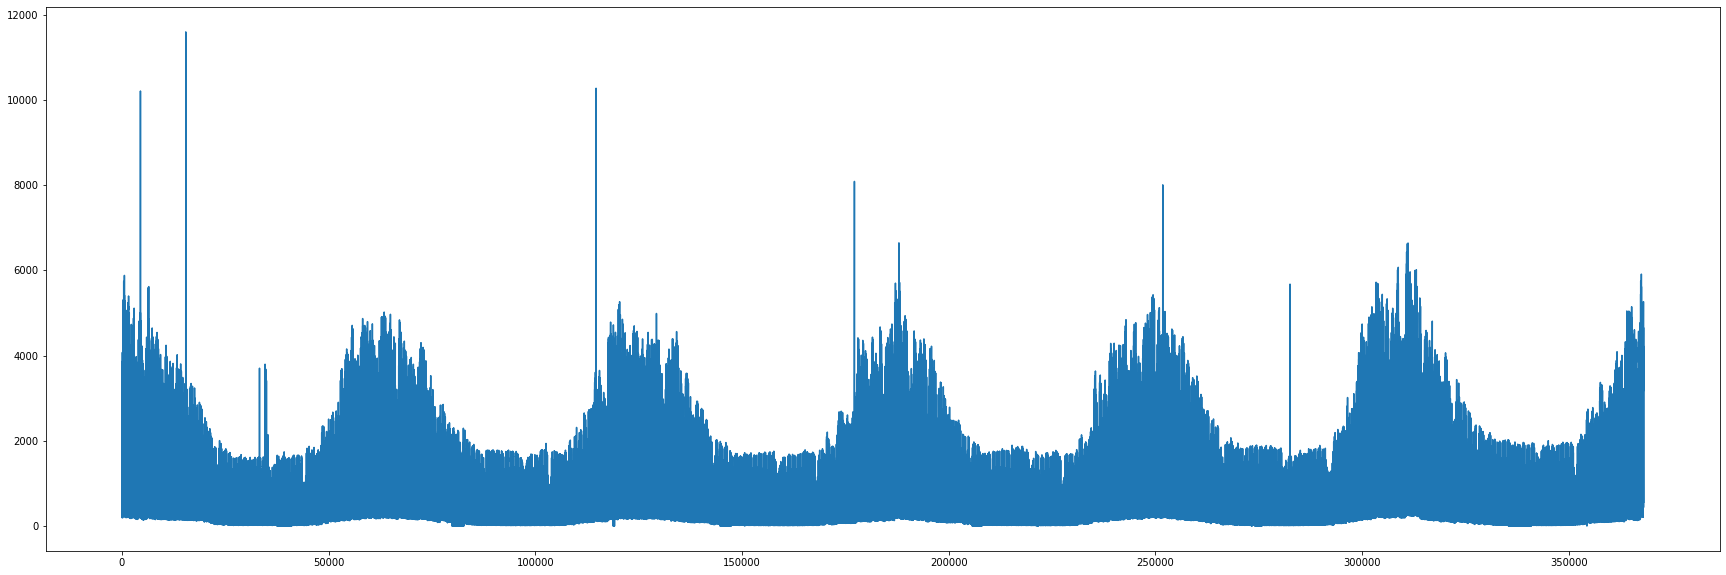

In [88]:
plt.figure(figsize=(30,10))
plt.plot(total['공급량'])# 주기? 계절?

<BarContainer object of 6 artists>

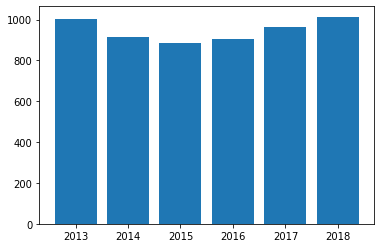

In [89]:
mean_year = total.groupby('year').mean()
plt.bar(mean_year.index,mean_year['공급량'])

<BarContainer object of 31 artists>

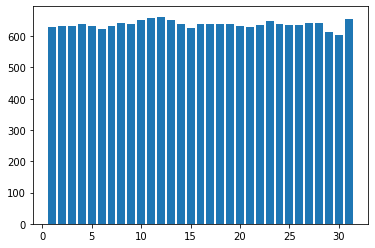

In [90]:
mean_year = total.groupby('day').median()
plt.bar(mean_year.index,mean_year['공급량'])

<BarContainer object of 24 artists>

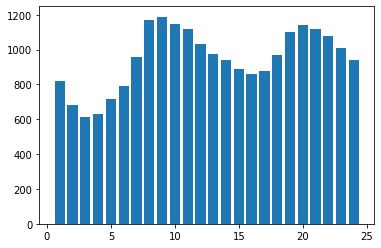

In [91]:
mean_hour = total.groupby('시간').mean()
plt.bar(mean_hour.index,mean_hour['공급량']) #시간별로 유의미한 차이가 있어보임

<BarContainer object of 12 artists>

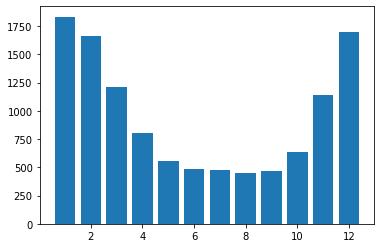

In [92]:
mean_month = total.groupby('month').mean()
plt.bar(mean_month.index,mean_month['공급량']) #계절성

In [93]:
total

,연월일,last_avg_windspeed,last_max_windspeed,last_rain,전일최저기온,전일평균기온,year,month,day,시간,구분,공급량,weekday,holiday
0,2013-01-01,2.2,6.5,0.0,-11.6,-8.7,2013,1,1,1,0,2497.129,1,0.0
1,2013-01-01,2.2,6.5,0.0,-11.6,-8.7,2013,1,1,2,0,2363.265,1,0.0
2,2013-01-01,2.2,6.5,0.0,-11.6,-8.7,2013,1,1,3,0,2258.505,1,0.0
3,2013-01-01,2.2,6.5,0.0,-11.6,-8.7,2013,1,1,4,0,2243.969,1,0.0
4,2013-01-01,2.2,6.5,0.0,-11.6,-8.7,2013,1,1,5,0,2344.105,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368083,2018-12-31,1.2,5.6,0.0,-11.3,-6.8,2018,12,31,20,6,681.033,0,0.0
368084,2018-12-31,1.2,5.6,0.0,-11.3,-6.8,2018,12,31,21,6,669.961,0,0.0
368085,2018-12-31,1.2,5.6,0.0,-11.3,-6.8,2018,12,31,22,6,657.941,0,0.0
368086,2018-12-31,1.2,5.6,0.0,-11.3,-6.8,2018,12,31,23,6,610.953,0,0.0


              연월일  last_avg_windspeed  ...  weekday  holiday
0      2013-01-01                 2.2  ...        1      0.0
1      2013-01-01                 2.2  ...        1      0.0
2      2013-01-01                 2.2  ...        1      0.0
3      2013-01-01                 2.2  ...        1      0.0
4      2013-01-01                 2.2  ...        1      0.0
...           ...                 ...  ...      ...      ...
368083 2018-12-31                 1.2  ...        0      0.0
368084 2018-12-31                 1.2  ...        0      0.0
368085 2018-12-31                 1.2  ...        0      0.0
368086 2018-12-31                 1.2  ...        0      0.0
368087 2018-12-31                 1.2  ...        0      0.0

[262920 rows x 14 columns]


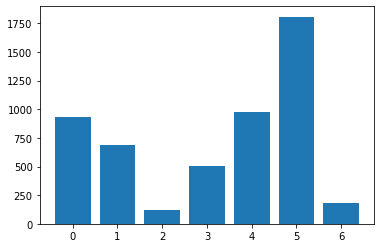

              연월일  last_avg_windspeed  ...  weekday  holiday
672    2013-01-05                 1.8  ...        5      1.0
673    2013-01-05                 1.8  ...        5      1.0
674    2013-01-05                 1.8  ...        5      1.0
675    2013-01-05                 1.8  ...        5      1.0
676    2013-01-05                 1.8  ...        5      1.0
...           ...                 ...  ...      ...      ...
367915 2018-12-30                 2.9  ...        6      1.0
367916 2018-12-30                 2.9  ...        6      1.0
367917 2018-12-30                 2.9  ...        6      1.0
367918 2018-12-30                 2.9  ...        6      1.0
367919 2018-12-30                 2.9  ...        6      1.0

[105168 rows x 14 columns]


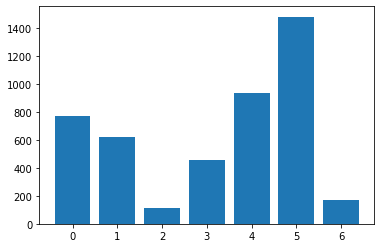

In [94]:

for i in range(2):
  p = total[total['holiday'] == i]
  print(p)
  p = p.groupby('구분').median()
  plt.bar(p.index,p['공급량'])
  plt.show()

              연월일  last_avg_windspeed  ...  weekday  holiday
0      2013-01-01                 2.2  ...        1      0.0
1      2013-01-01                 2.2  ...        1      0.0
2      2013-01-01                 2.2  ...        1      0.0
3      2013-01-01                 2.2  ...        1      0.0
4      2013-01-01                 2.2  ...        1      0.0
...           ...                 ...  ...      ...      ...
368083 2018-12-31                 1.2  ...        0      0.0
368084 2018-12-31                 1.2  ...        0      0.0
368085 2018-12-31                 1.2  ...        0      0.0
368086 2018-12-31                 1.2  ...        0      0.0
368087 2018-12-31                 1.2  ...        0      0.0

[262920 rows x 14 columns]


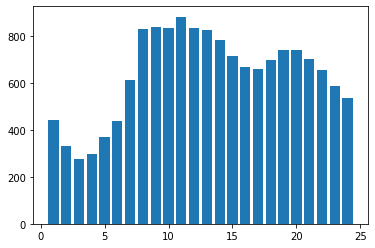

              연월일  last_avg_windspeed  ...  weekday  holiday
672    2013-01-05                 1.8  ...        5      1.0
673    2013-01-05                 1.8  ...        5      1.0
674    2013-01-05                 1.8  ...        5      1.0
675    2013-01-05                 1.8  ...        5      1.0
676    2013-01-05                 1.8  ...        5      1.0
...           ...                 ...  ...      ...      ...
367915 2018-12-30                 2.9  ...        6      1.0
367916 2018-12-30                 2.9  ...        6      1.0
367917 2018-12-30                 2.9  ...        6      1.0
367918 2018-12-30                 2.9  ...        6      1.0
367919 2018-12-30                 2.9  ...        6      1.0

[105168 rows x 14 columns]


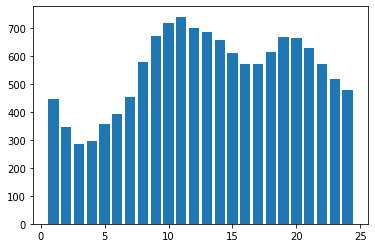

In [95]:

for i in range(2):
  p = total[total['holiday'] == i]
  print(p)
  p = p.groupby('시간').median()
  plt.bar(p.index,p['공급량'])
  plt.show()

In [96]:
train_years = [2013,2014,2015,2016,2017]
val_years = [2018]

In [97]:
total = total.rename(columns = {'구분':'station','전일최저기온':'low_temp','전일평균기온':'avg_temp', '시간': 'hour'})

In [98]:
total

,연월일,last_avg_windspeed,last_max_windspeed,last_rain,low_temp,avg_temp,year,month,day,hour,station,공급량,weekday,holiday
0,2013-01-01,2.2,6.5,0.0,-11.6,-8.7,2013,1,1,1,0,2497.129,1,0.0
1,2013-01-01,2.2,6.5,0.0,-11.6,-8.7,2013,1,1,2,0,2363.265,1,0.0
2,2013-01-01,2.2,6.5,0.0,-11.6,-8.7,2013,1,1,3,0,2258.505,1,0.0
3,2013-01-01,2.2,6.5,0.0,-11.6,-8.7,2013,1,1,4,0,2243.969,1,0.0
4,2013-01-01,2.2,6.5,0.0,-11.6,-8.7,2013,1,1,5,0,2344.105,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368083,2018-12-31,1.2,5.6,0.0,-11.3,-6.8,2018,12,31,20,6,681.033,0,0.0
368084,2018-12-31,1.2,5.6,0.0,-11.3,-6.8,2018,12,31,21,6,669.961,0,0.0
368085,2018-12-31,1.2,5.6,0.0,-11.3,-6.8,2018,12,31,22,6,657.941,0,0.0
368086,2018-12-31,1.2,5.6,0.0,-11.3,-6.8,2018,12,31,23,6,610.953,0,0.0


In [100]:
train = total[total['year'].isin(train_years)]
val = total[total['year'].isin(val_years)]

In [106]:
import xgboost as xgb
from xgboost import XGBRegressor
features = ['station','last_avg_windspeed', 'last_max_windspeed', 'last_rain', 'low_temp','avg_temp',"month",'day',"hour",'holiday','weekday']
train_x = train[features]
train_y = train['공급량']

val_x = val[features]
val_y = val['공급량']


In [107]:
from sklearn.metrics import mean_squared_error

def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [108]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error

# regularization candiate 정의
reg_candidate = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100]

# space 정의, Hyperparameter의 이름을 key 값으로 입력
space={'max_depth': hp.quniform("max_depth", 5, 15, 1),
       'learning_rate': hp.quniform ('learning_rate', 0.01, 0.05, 0.005),
       'reg_alpha' : hp.choice('reg_alpha', reg_candidate),
       'reg_lambda' : hp.choice('reg_lambda', reg_candidate),
       'subsample': hp.quniform('subsample', 0.6, 1, 0.05),
       'colsample_bytree' : hp.quniform('colsample_bytree', 0.6, 1, 0.05),
       'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
       'n_estimators': hp.quniform('n_estimators', 200, 1500, 100)
      }

# 목적 함수 정의
# n_estimators, max_depth와 같은 반드시 int 타입을 가져야 하는 hyperparamter는 int로 타입 캐스팅 합니다.
def hyperparameter_tuning(space):
    model=XGBRegressor(n_estimators =int(space['n_estimators']),
                       objective='reg:squarederror', 
                       max_depth = int(space['max_depth']), 
                       learning_rate = space['learning_rate'],
                       reg_alpha = space['reg_alpha'],
                       reg_lambda = space['reg_lambda'],
                       subsample = space['subsample'],
                       colsample_bytree = space['colsample_bytree'], 
                       min_child_weight = int(space['min_child_weight']),
                       random_state=42, 
                      )
    
    evaluation = [(train_x, train_y), (val_x, val_y)]
    
    model.fit(train_x, train_y,
              eval_set=evaluation, 
              eval_metric="rmse",
              early_stopping_rounds=20,
              verbose=0)

    pred = model.predict(val_x)
    rmse= RMSE(val_y, pred)    
    # 평가 방식 선정
    return {'loss':rmse, 'status': STATUS_OK, 'model': model}

In [124]:
trials = Trials()
# best에 최적의 하이퍼 파라미터를 return 받습니다.
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=30, # 최대 반복 횟수를 지정합니다.
            trials=trials)

# 최적화된 결과를 int로 변환해야하는 파라미터는 타입 변환을 수행합니다.
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])
best['n_estimators'] = int(best['n_estimators'])
best['reg_alpha'] = reg_candidate[int(best['reg_alpha'])]
best['reg_lambda'] = reg_candidate[int(best['reg_lambda'])]
best['random_state'] = 42
print (best)

 33%|███▎      | 10/30 [1:06:18<2:12:37, 397.87s/it, best loss: 173.2034731959083]


KeyboardInterrupt: ignored

In [126]:
my_model = XGBRegressor(**best)
hist = my_model.fit(train_x, train_y, 
                    early_stopping_rounds=100, 
                    eval_set=[(train_x, train_y), (val_x, val_y)], eval_metric='rmse', 
                    verbose=20)

NameError: ignored

In [127]:
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()
train_x = my_imputer.fit_transform(train_x)
val_x = my_imputer.transform(val_x)
my_model = XGBRegressor(n_estimators=500, 
                        max_depth=5, 
                        learning_rate=0.1, 
                        subsample=0.7, 
                        colsample_bytree=0.8, 
                        colsample_bylevel=0.8, 
                        base_score=train_y.mean(), 
                        random_state=42, seed=42)
hist = my_model.fit(train_x, train_y, 
                    early_stopping_rounds=10, 
                    eval_set=[(val_x, val_y)], eval_metric='rmse', 
                    verbose=20)


[18:47:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:936.021
Will train until validation_0-rmse hasn't improved in 10 rounds.
[20]	validation_0-rmse:360.835
[40]	validation_0-rmse:254.064
[60]	validation_0-rmse:213.815
[80]	validation_0-rmse:201.958
[100]	validation_0-rmse:194.939
[120]	validation_0-rmse:191.422
[140]	validation_0-rmse:188.735
[160]	validation_0-rmse:187.56
[180]	validation_0-rmse:185.472
[200]	validation_0-rmse:184.106
[220]	validation_0-rmse:182.539
[240]	validation_0-rmse:181.519
[260]	validation_0-rmse:180.56
[280]	validation_0-rmse:180.314
Stopping. Best iteration:
[272]	validation_0-rmse:180.063



In [128]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(train_x,feature_names = features,mode= 'regression')

In [129]:
val_y.iloc[72]

1058.893

In [130]:
exp = explainer.explain_instance(val_x[72], my_model.predict, num_features=17)
exp.show_in_notebook(show_table=True)
#3.40
#-0.70
#1.00
#18.25

[Text(0, 0, 'station'),
 Text(0, 0, 'last_avg_windspeed'),
 Text(0, 0, 'last_max_windspeed'),
 Text(0, 0, 'last_rain'),
 Text(0, 0, 'low_temp'),
 Text(0, 0, 'avg_temp'),
 Text(0, 0, 'month'),
 Text(0, 0, 'day'),
 Text(0, 0, 'hour'),
 Text(0, 0, 'holiday'),
 Text(0, 0, 'weekday')]

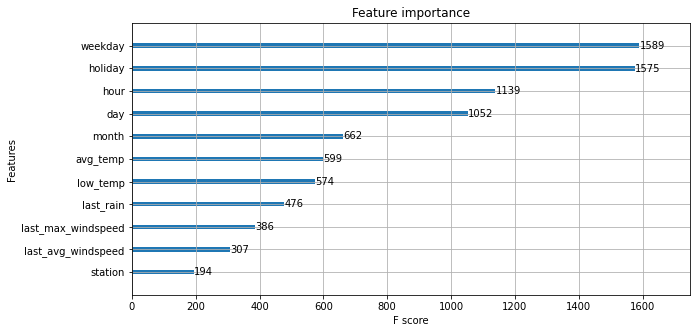

In [131]:
from matplotlib.pylab import rcParams
from xgboost import plot_importance 
rcParams['figure.figsize'] = 10, 5
plot_importance(my_model).set_yticklabels(features)

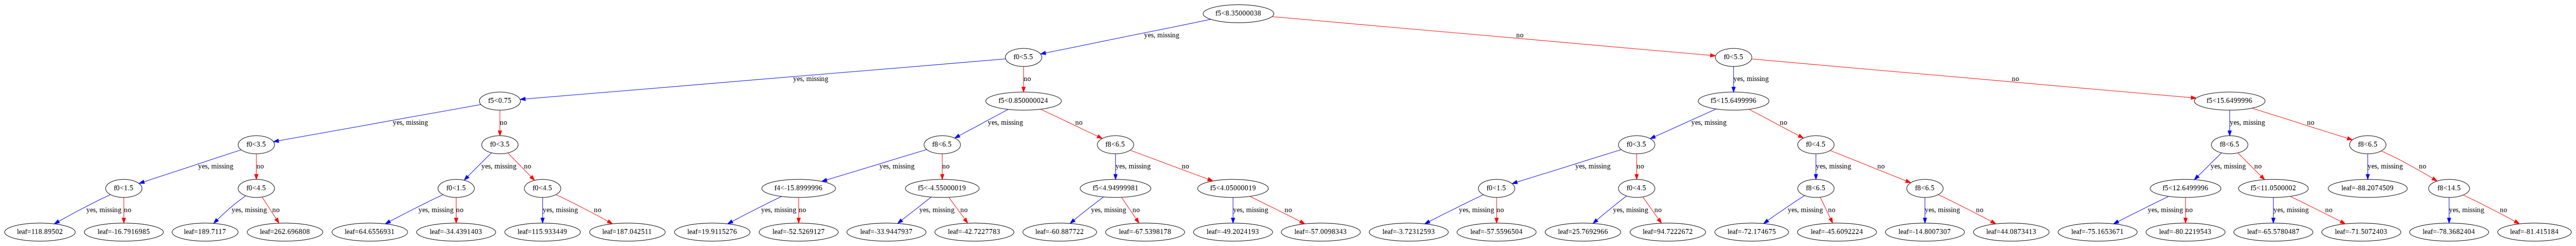

In [151]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 120,120

plot_tree(my_model)
plt.show()